# Exploratory Data Analysis — Fraud Detection (IEEE-CIS)

## Objective
The objective of this notebook is to perform exploratory data analysis (EDA) on the IEEE-CIS Fraud Detection dataset from a real-world fintech perspective.

This analysis is not focused on visualization aesthetics.
Instead, it aims to understand:

- Fraud behavior and imbalance

- Temporal dynamics of fraud

- Data quality and missingness

- Early signals for feature engineering

- Risks of data leakage



In [3]:
# Imports & Setup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)




In [4]:
# Load the Dataset

DATA_PATH = "../data/"

train_trans = pd.read_csv(DATA_PATH + "train_transaction.csv")
train_id = pd.read_csv(DATA_PATH + "train_identity.csv")

print(train_trans.shape)
print(train_id.shape)


(590540, 394)
(144233, 41)


## Notes

- The transaction table contains all transaction events.

- Identity information is optional and missing for a large portion of transactions.

- Missing identity data may itself be a useful fraud signal.

In [6]:
# Merge Transaction and Identity Tables

df = train_trans.merge(train_id, on='TransactionID', how='left')
print(df.shape)

# Get all column names
columns = df.columns.tolist()
print(f"Total columns: {len(columns)}")

# store columns in a Json file
import json

schema = {"columns": columns}

with open("schema.json", "w") as f:
    json.dump(schema, f, indent=4)  # indent=4 makes it readable


(590540, 434)
Total columns: 434


In [4]:
# Target Variable: Fraud Rate
Fraud_rate = df['isFraud'].mean()
print(f'Fraud Rate is :', Fraud_rate)


Fraud Rate is : 0.03499000914417313


In [5]:
fraud_counts = df["isFraud"].value_counts(normalize=True) * 100
print('Fraud class distribution:')
print(fraud_counts )

Fraud class distribution:
isFraud
0   96.5010
1    3.4990
Name: proportion, dtype: float64


## Key Insight

- Fraud rate is approximately 3–4%, indicating a highly imbalanced dataset.

- Accuracy will not be a meaningful evaluation metric for this problem

C:\Users\Mohsu\AppData\Local\Temp\ipykernel_17248\349295562.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sorted.groupby(


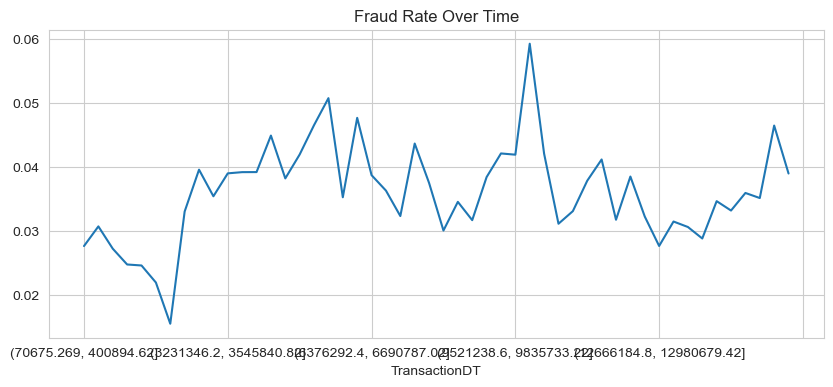

In [6]:
# Fraud Over Time
df_sorted = df.sort_values("TransactionDT")

df_sorted.groupby(
    pd.cut(df_sorted["TransactionDT"], bins=50)
)["isFraud"].mean().plot(figsize=(10,4), title="Fraud Rate Over Time")
plt.show()


## Key Insight

- Fraud does not occur uniformly over time.

- There are visible fluctuations, suggesting fraud waves or bursts.

This confirms that:

- Time-aware train/validation splits are required

- Random splits would introduce data leakage

- Fraud is a dynamic process, not a static classification problem.


In [7]:
# Transaction Amount Analysis
df['TransactionAmt'].describe()

count   590540.0000
mean       135.0272
std        239.1625
min          0.2510
25%         43.3210
50%         68.7690
75%        125.0000
max      31937.3910
Name: TransactionAmt, dtype: float64

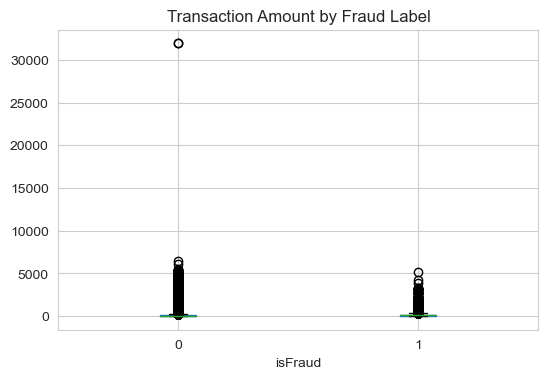

In [9]:
# Compare fraud vs non-fraud

df.boxplot(
    column="TransactionAmt",
    by="isFraud",
    figsize=(6,4)
)
plt.title("Transaction Amount by Fraud Label")
plt.suptitle("")
plt.show()


## Key Insight

- Fraudulent transactions exhibit higher variance in transaction amounts.

- Raw transaction amount alone is insufficient for detection.

- Relative features (e.g., deviation from normal behavior) will be more informative.

In [ ]:
# Categorical Features (Fraud Distribution)
# 1.Start with ProductCD:
pd.crosstab(
    df["ProductCD"],
    df["isFraud"],
    normalize="index"
).sort_values(1, ascending=False)

isFraud,0,1
ProductCD,,
C,0.8831,0.1169
S,0.9410,0.0590
H,0.9523,0.0477
R,0.9622,0.0378
W,0.9796,0.0204


In [11]:
# 2. Then Email Domains 

pd.crosstab(
    df["P_emaildomain"],
    df["isFraud"],
    normalize="index"
).sort_values(1, ascending=False).head(10)


isFraud,0,1
P_emaildomain,,
protonmail.com,0.5921,0.4079
mail.com,0.8104,0.1896
outlook.es,0.8699,0.1301
aim.com,0.8730,0.1270
outlook.com,0.9054,0.0946
hotmail.es,0.9344,0.0656
live.com.mx,0.9453,0.0547
hotmail.com,0.9470,0.0530
gmail.com,0.9565,0.0435


## Key Insight

- Certain categorical values show higher fraud ratios.

- These features are useful but must be handled carefully to avoid overfitting.

In [12]:
# Missing Values 
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct.head(20)


id_24   0.9920
id_25   0.9913
id_07   0.9913
id_08   0.9913
id_21   0.9913
id_26   0.9913
id_27   0.9912
id_23   0.9912
id_22   0.9912
dist2   0.9363
D7      0.9341
id_18   0.9236
D13     0.8951
D14     0.8947
D12     0.8904
id_03   0.8877
id_04   0.8877
D6      0.8761
id_33   0.8759
id_10   0.8731
dtype: float64

In [ ]:
missing_pct[missing_pct > 0.5]

id_24   0.9920
id_25   0.9913
id_07   0.9913
id_08   0.9913
id_21   0.9913
         ...  
M5      0.5935
M7      0.5864
M9      0.5863
M8      0.5863
D5      0.5247
Length: 214, dtype: float64

## Key Insight

- Identity-related features are frequently missing.

- Missingness is not random and may correlate with fraud behavior.

- Missing-value indicators will be explicitly engineered in later stages.

In [14]:
# Leakage Sanity Check
numeric_cols = df.select_dtypes(include=np.number).columns

corr = df[numeric_cols].corr()['isFraud'].sort_values(ascending=False)
corr.head(10)

isFraud   1.0000
V257      0.3831
V246      0.3669
V244      0.3641
V242      0.3606
V201      0.3280
V200      0.3188
V189      0.3082
V188      0.3036
V258      0.2972
Name: isFraud, dtype: float64

Guiding Principle

- Extremely high correlations should be treated with suspicion.

- Any feature that appears “too predictive” will be carefully reviewed for leakage.

- If a feature looks too good to be true, it usually is.

## EDA Summary — Fraud Perspective

Summary of findings

- The dataset is highly imbalanced, consistent with real-world fraud.

- Fraud patterns vary over time, confirming non-stationarity.

- Transaction amount alone is weak; behavioral deviation is required.

- Certain categorical features exhibit elevated fraud risk.

- Identity information is often missing and may be predictive.

- Time-aware splitting is mandatory to avoid data leakage.